In [1]:
import os
import sys
import networkx as nx
import numpy as np
from epynet import Network

sys.path.insert(0, os.path.join('..', 'utils'))
from graph_utils import get_nx_graph
from sensor_placement_methods import SensorInstaller

In [2]:
wds_id = 'anytown'

In [3]:
path_to_data = os.path.join('..', 'data', 'db_'+wds_id+'_doe_pumpfed_1')
path_to_wds = os.path.join('..', 'water_networks', wds_id+'.inp')

### Loading WDS topology

In [4]:
wds = Network(path_to_wds)
G = get_nx_graph(wds, mode='weighted')
installer = SensorInstaller(wds)

In [5]:
coords = {}
for node in wds.nodes:
    arr = [node.coordinates[0], node.coordinates[1]]
    coords[int(node.index)] = arr

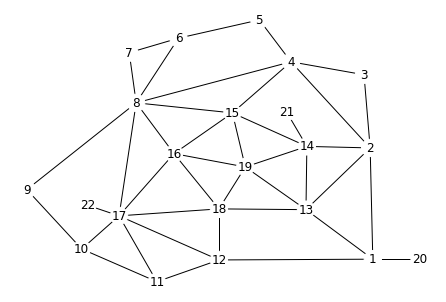

In [6]:
node_colors = ['#ffffff' for _ in G.nodes]
nx.draw(G, pos=coords, with_labels=True, node_color=node_colors)

### Collecting master nodes

In [7]:
master_nodes = installer.master_nodes

### Shortest path selection

In [8]:
sensor_budget = 5
sensor_nodes = set()

In [9]:
for _ in range(sensor_budget):
    path_lengths = dict()
    for node in G.nodes:
        path_lengths[node] = 0
    for node in master_nodes.union(sensor_nodes):
        tempo = nx.shortest_path_length(G, source=node, weight='weight')
#         tempo = nx.shortest_path_length(G, source=node, weight=None)
        for key, value in tempo.items():
            if key not in master_nodes.union(sensor_nodes):
                path_lengths[key] += value
    sensor_nodes.add([candidate for candidate, path_length in path_lengths.items() 
                      if path_length == np.max(list(path_lengths.values()))][0])

### Sensor placement plot

In [10]:
node_arr = np.array(G.nodes)
node_colors = ['#ffffff' for _ in G.nodes]
for node in master_nodes:
    try:
        node_colors[np.where(node_arr == node)[0][0]] = '#ff0000'
    except:
        print(node)
for node in sensor_nodes:
    node_colors[np.where(node_arr == node)[0][0]] = '#008000'

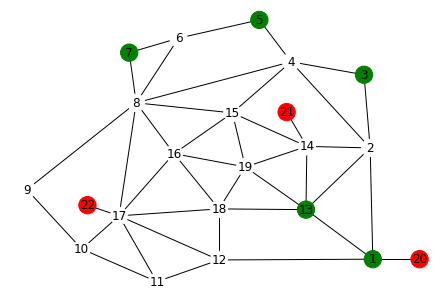

In [11]:
nx.draw(G, pos=coords, with_labels=True, node_color=node_colors, alpha=None)

### Sensitivity matrix

In [12]:
wds.solve()

delta_demand = np.max(wds.junctions.basedemand)/100
base_demands = wds.junctions.basedemand
base_heads = wds.junctions.head
S = np.zeros((len(wds.junctions), len(wds.junctions)), dtype=np.float64)

In [13]:
for i, junc in enumerate(wds.junctions):
    wds.junctions.basedemand = base_demands
    junc.basedemand += delta_demand
    wds.solve()
    S[i, :] = (wds.junctions.head-base_heads) / base_heads

In [14]:
sensor_nodes = set(np.argsort(np.sum(S, axis=0))[:sensor_budget])

In [15]:
node_arr = np.array(G.nodes)
node_colors = ['#ffffff' for _ in G.nodes]
for node in master_nodes:
    try:
        node_colors[np.where(node_arr == node)[0][0]] = '#ff0000'
    except:
        print(node)
for node in sensor_nodes:
    node_colors[np.where(node_arr == node)[0][0]] = '#008000'

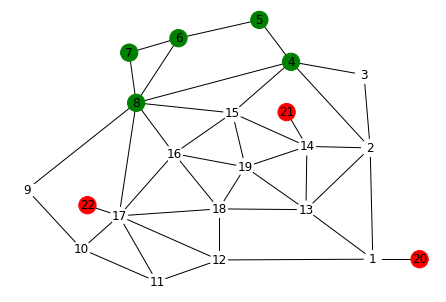

In [16]:
nx.draw(G, pos=coords, with_labels=True, node_color=node_colors, alpha=None)

# Interface tests

In [17]:
from DataReader import DataReader

In [18]:
seed = 12

In [19]:
obsrat = sensor_budget/len(G.nodes)
print(obsrat)

reader = DataReader(path_to_data, n_junc=len(G.nodes), obsrat=obsrat, seed=seed)
dta, _, _ = reader.read_data(dataset='trn', varname='junc_heads', rescale=None, cover=True)

0.22727272727272727


In [20]:
installer.random_deploy(sensor_budget=sensor_budget, seed=seed)
sensor_nodes = installer.sensor_nodes

In [21]:
dta[0,:,1]

array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0.])

In [22]:
reader.obs_ind.compute()

array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0.])

In [23]:
sensor_nodes

{4, 12, 13, 16, 21}

In [24]:
signal_mask = np.zeros(shape=(len(wds.junctions),))

In [25]:
indices = []
for node in sensor_nodes:
    indices.append(np.where(list(G.nodes) == node)[0][0])

In [26]:
signal_mask[indices] = 1

In [27]:
signal_mask

array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0.])